# 2 Metop-A/B/C GOME-2 - Absorbing Aerosol Index (AAI) - Level 3

### About

The following example introduces you to the Absorbing Aerosol Index (AAI) Level 3 data product from the GOME-2 instrument onboard the three Metop satellites Metop-A/B/C.

The Absorbing Aerosol Index (AAI) indicates the presence of elevated absorbing aerosols in the Earth's atmosphere. The aerosol types that are mostly seen in the AAI are `desert dust` and `biomass burning aerosols`. The Absorbing Aerosol Index is derived from reflectances measured by GOME-2 at 340 and 380 nm. 

The data of the Metop-A/B/C GOME-2 `Absorbing Aerosol Index (AAI)` are provided by KNMI in the framework of the [EUMETSAT Satellite Application Facility on Atmospheric Composition Monitoring (AC SAF)](https://acsaf.org).

Find more information on the GOME-2 Level 3 AAI data product processed by KNMI [here](https://acsaf.org/docs/pum/Product_User_Manual_NAR_NAP_ARS_ARP_Apr_2020.pdf).

### Basic Facts

> **Spatial resolution**: `1° x 1°`, gridded onto a regular lat-lon grid <br>
> **Spatial coverage**: `Global` <br>
> **Temporal resolution**:  `daily and monthly aggregates` <br>
> **Data availability**: `Metop-A: since 2007`, `Metop-B: since 2012`, `Metop-C: since 2019`


### How to access the data

AAI Level 3 data are available in for download via [TEMIS](http://www.temis.nl/airpollution/absaai/), a web-based service for atmospheric satellite data products maintained by KNMI. TEMIS provides daily and monthly aggregated Level 3 (gridded) data products for the three satellites Metop-A, -B, and -C, in netCDF format. Go to the [download page](https://www.temis.nl/airpollution/absaai/#GOME2_AAI).

### Module outline
* [1 - Load and browse Metop-A GOME-2 Level 3 AAI data](#load_browse_gome2)
* [2 - Concatenate the data from the three satellites Metop-A, -B and -C](#concat_gome2)
* [3 - Retrieve  time coordinate information and assign time coordinates to the time dimension](#assign_time_coord_gome2)
* [4 - Combine AAI data from the three satellites Metop-A, -B, and -C onto one single grid](#combine_gome2)
* [5 - Visualize AAI data with data from the three satellites Metop-A, -B, and C combined on one single grid](#visualize_gome2)
* [6 - Animate daily Metop-A/B/C GOME-2 Level 3 Absorbed Aerosol Index (AAI) data](#animate_gome2)



<hr>

##### Load required libraries

In [1]:
import sys
!{sys.executable} -m pip install cartopy netCDF4 h5netcdf==1.3.0 satpy==0.51.0 pyhdf h5py python-geotiepoints

In [2]:
import xarray as xr
import pandas as pd
from datetime import datetime

import os
os.environ['PROJ_LIB'] = '/opt/conda/share/proj'

# Python libraries for visualisation
from matplotlib import pyplot as plt
from matplotlib import animation

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from IPython.display import HTML

##### Load helper functions

In [3]:
if os.path.exists("functions.ipynb"):
    %run functions.ipynb
elif os.path.exists("../functions.ipynb"):
    %run ../functions.ipynb
else:
    print("Helper functions notebook not found in any specified path. Downloading from Gitlab.")    
    !wget https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/raw/master/functions.ipynb
    %run functions.ipynb

In [4]:
if os.path.exists("bucket_functions.ipynb"):
    %run bucket_functions.ipynb
elif os.path.exists("../bucket_functions.ipynb"):
    %run ../bucket_functions.ipynb
else:
    print("Helper functions notebook not found in any specified path. Downloading from Gitlab.")    
    #!wget https://gitlab.eumetsat.int/eumetlab/atmosphere/atmosphere/-/raw/master/bucket_functions.ipynb
    %run bucket_functions.ipynb

In [5]:
base_url = 'https://s3.waw3-2.cloudferro.com/swift/v1/wmo/'
all_paths_list = list_data_on_bucket(base_url)

all_directories_list = [os.path.dirname(path) for path in all_paths_list if path.count('/') <= 4]
# Take unique directories
all_directories_list = list(np.unique(all_directories_list))
all_directories_list

Status ok



[np.str_('eodata'),
 np.str_('eodata/fci'),
 np.str_('eodata/fci/W_XX-EUMETSAT-Darmstadt,IMG+SAT,MTI1+FCI-1C-RRAD-FDHSI-FD--x-x---x_C_EUMT_20240924092245_IDPFI_OPE_20240924092007_20240924092928_N__C_0057_0000'),
 np.str_('eodata/gome2'),
 np.str_('eodata/gome2/aai'),
 np.str_('eodata/gome2/hcho'),
 np.str_('eodata/gome2/hcho/daily'),
 np.str_('eodata/gome2/no2'),
 np.str_('eodata/gome2/no2/daily'),
 np.str_('eodata/iasi'),
 np.str_('eodata/iasi/co'),
 np.str_('eodata/iasi/nh3'),
 np.str_('eodata/meteosat'),
 np.str_('eodata/meteosat/2020'),
 np.str_('eodata/meteosat/2024'),
 np.str_('eodata/modis'),
 np.str_('eodata/modis/10km'),
 np.str_('eodata/modis/level_1b'),
 np.str_('eodata/monarch'),
 np.str_('eodata/pmap'),
 np.str_('eodata/s3'),
 np.str_('eodata/s3/aod'),
 np.str_('eodata/s3/aod/S3A_SL_2_AOD____20240821T082340_20240821T082839_20240821T101507_0299_116_078______MAR_O_NR_003.SEN3'),
 np.str_('eodata/s3/aod/S3A_SL_2_AOD____20240825T081954_20240825T082453_20240825T101112_0299_116_

#### Define geographical extent

In [6]:
latmin = 0
latmax = 40
lonmin = -50
lonmax = 20

<hr>

## <a id='load_browse_gome2'></a>1. Load and browse Metop-A GOME-2 Level 3 AAI data

The Metop-A/B/C GOME-3 Level 3 AAI data files can be downloaded from the TEMIS website in `NetCDF` data format. TEMIS offers the data of all three satellites Metop-A, -B and -C, which, combined, provide daily measurements for the entire globe.

The following example uses daily gridded AAI data from the three satellites Metop-A, -B, and -C for 3 consecutive days between `14 to 19 June 2020`. The example shows the dispersion of aerosols during the Saharan dust event over part of south-east France, Switzerland and northern Italy.

Daily gridded data is available for each satellite. Thus, the first step is to inspect one file to get a better understanding of the general data structure. Followed by loading the data files for the entire time period into one `xarray.DataArray` and to repeat this for each of the three satellites Metop-A, -B and -C.

### Inspect the structure of one daily gridded AAI data file

The data is in the folder `../../eodata/1_satellite/gome2/aai`. Since the data is distributed in the `NetCDF` format, you can use the xarray function `xr.open_dataset()` to load one single file to better understand the data structure.

In [7]:
data_path = base_url+'eodata/gome2/aai/ESACCI-AEROSOL-L3-AAI-GOME2A-1D-20200614-fv1.9.nc'
aai_gome2a = open_data_from_bucket(data_path)

File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/aai/ESACCI-AEROSOL-L3-AAI-GOME2A-1D-20200614-fv1.9.nc


The output of the `xarray.Dataset` above shows that one file contains the data of three variables: <br>
* `absorbing_aerosol_index`,
* `number_of_observations`, and
* `solar_zenith_angle`. 

The variable of interest is `absorbing aerosol_index`. By adding the variable of interest into square brackets `[]`, you can select the data variable. Variables are stored as `xarray.DataArray`. You can see that the daily gridded data are on a 1 deg x 1 deg data grid, with 180 latitude values and 360 longitude values.

In [8]:
aai = aai_gome2a['absorbing_aerosol_index']
aai

<xarray.DataArray 'absorbing_aerosol_index' (longitude: 360, latitude: 180)> Size: 259kB
[64800 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

<br>

### Load a time-series of daily Metop-A GOME-2 Level 3 AAI data into one `xarray.Dataset`

The xarray `open_mfdataset()` function allows the opening of multiple files at once. You have to specify the dimension the files shall be concatenated by. It can be an existing dimension within the data file or a new dimension, which is newly specified.

Let us open the daily gridded AAI data from Metop-A for the 3 days from 5 to 7 February 2021. We specify `time` as a new dimension that the data files shall be concatenated by. After you loaded the multiple files in a `Dataset` with the function `open_mfdataset()`, you have to select `absorbing_aerosol_index` again as the variable of interest.

The resulting `xarray.DataArray` has three dimensions (`time`, `latitude` and `longitude`).


In [9]:
aai_files = [base_url + path for path in all_paths_list if 'AAI-GOME2A' in path and path.endswith('.nc')]

datasets = list()
for file in aai_files:
    datasets.append(open_data_from_bucket(file))

ds = xr.concat(datasets, dim='time')
aai_a = ds['absorbing_aerosol_index']
aai_a

File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/aai/ESACCI-AEROSOL-L3-AAI-GOME2A-1D-20200614-fv1.9.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/aai/ESACCI-AEROSOL-L3-AAI-GOME2A-1D-20200615-fv1.9.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/aai/ESACCI-AEROSOL-L3-AAI-GOME2A-1D-20200616-fv1.9.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/aai/ESACCI-AEROSOL-L3-AAI-GOME2A-1D-20200617-fv1.9.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/aai/ESACCI-AEROSOL-L3-AAI-GOME2A-1D-20200618-fv1.9.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/aai/ESACCI-AEROSOL-L3-AAI-GOME2A-1D-20200619-fv1.9.nc


<xarray.DataArray 'absorbing_aerosol_index' (time: 6, longitude: 360,
                                             latitude: 180)> Size: 2MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]],
      shape=(6, 360, 180), dtype=float32)
Coordinates:
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Dimensions without coordinates: time
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

<br>

The same process has to be repeated for the daily gridded AAI data from the satellites Metop-B and Metop-C respectively.
Below, we load the GOME-2 Level 3 AAI data from the Metop-B satellite.

In [10]:
aai_files = [base_url + path for path in all_paths_list if 'AAI-GOME2B' in path and path.endswith('.nc')]

datasets = list()
for file in aai_files:
    datasets.append(open_data_from_bucket(file))

ds = xr.concat(datasets, dim='time')
aai_b = ds['absorbing_aerosol_index']
aai_b

File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/aai/ESACCI-AEROSOL-L3-AAI-GOME2B-1D-20200614-fv1.9.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/aai/ESACCI-AEROSOL-L3-AAI-GOME2B-1D-20200615-fv1.9.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/aai/ESACCI-AEROSOL-L3-AAI-GOME2B-1D-20200616-fv1.9.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/aai/ESACCI-AEROSOL-L3-AAI-GOME2B-1D-20200617-fv1.9.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/aai/ESACCI-AEROSOL-L3-AAI-GOME2B-1D-20200618-fv1.9.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/aai/ESACCI-AEROSOL-L3-AAI-GOME2B-1D-20200619-fv1.9.nc


<xarray.DataArray 'absorbing_aerosol_index' (time: 6, longitude: 360,
                                             latitude: 180)> Size: 2MB
array([[[        nan,         nan,         nan, ..., -0.07148454,
          0.01395808,  0.05875817],
        [        nan,         nan,         nan, ..., -0.09433368,
          0.02558051,  0.10912121],
        [        nan,         nan,         nan, ..., -0.08581331,
          0.02140067,  0.00466279],
        ...,
        [        nan,         nan,         nan, ..., -0.10055962,
          0.03922263,  0.14900401],
        [        nan,         nan,         nan, ..., -0.09604355,
          0.02759371,  0.07408196],
        [        nan,         nan,         nan, ..., -0.09481632,
          0.05454236,  0.11412998]],

       [[        nan,         nan,         nan, ..., -0.22125058,
         -0.27718744, -0.3091163 ],
        [        nan,         nan,         nan, ..., -0.2244205 ,
         -0.2609748 , -0.31654024],
        [        nan,         nan,         nan, ..., -0.21404117,
         -0.28232977, -0.34362426],
...
        [        nan,         nan,         nan, ..., -0.15934369,
         -0.37654093, -0.39627397],
        [        nan,         nan,         nan, ..., -0.1808701 ,
         -0.37612236, -0.45503846],
        [        nan,         nan,         nan, ..., -0.18483762,
         -0.39048728, -0.45864508]],

       [[        nan,         nan,         nan, ..., -0.2697014 ,
         -0.3454974 , -0.19745554],
        [        nan,         nan,         nan, ..., -0.25915042,
         -0.34297037, -0.2146123 ],
        [        nan,         nan,         nan, ..., -0.25725144,
         -0.33761758, -0.19318044],
        ...,
        [        nan,         nan,         nan, ..., -0.22332773,
         -0.34934875, -0.24020027],
        [        nan,         nan,         nan, ..., -0.24257967,
         -0.34717864, -0.16366172],
        [        nan,         nan,         nan, ..., -0.24480067,
         -0.33742633, -0.25296655]]], shape=(6, 360, 180), dtype=float32)
Coordinates:
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Dimensions without coordinates: time
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

<br>

And here, we load the daily gridded GOME-2 AAI Level 3 data files from the Metop-C satellite.

In [11]:
aai_files = [base_url + path for path in all_paths_list if 'AAI-GOME2C' in path and path.endswith('.nc')]

datasets = list()
for file in aai_files:
    datasets.append(open_data_from_bucket(file))

ds = xr.concat(datasets, dim='time')

aai_c=ds['absorbing_aerosol_index']
aai_c

File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/aai/ESACCI-AEROSOL-L3-AAI-GOME2C-1D-20200614-fv1.9.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/aai/ESACCI-AEROSOL-L3-AAI-GOME2C-1D-20200615-fv1.9.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/aai/ESACCI-AEROSOL-L3-AAI-GOME2C-1D-20200616-fv1.9.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/aai/ESACCI-AEROSOL-L3-AAI-GOME2C-1D-20200617-fv1.9.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/aai/ESACCI-AEROSOL-L3-AAI-GOME2C-1D-20200618-fv1.9.nc
File opened: https://s3.waw3-2.cloudferro.com/swift/v1/wmo/eodata/gome2/aai/ESACCI-AEROSOL-L3-AAI-GOME2C-1D-20200619-fv1.9.nc


<xarray.DataArray 'absorbing_aerosol_index' (time: 6, longitude: 360,
                                             latitude: 180)> Size: 2MB
array([[[            nan,             nan,             nan, ...,
          1.56462431e-01,  2.67972618e-01,  3.11094224e-01],
        [            nan,             nan,             nan, ...,
          1.36820018e-01,  2.34541222e-01,  3.32028985e-01],
        [            nan,             nan,             nan, ...,
          1.38059691e-01,  2.23571405e-01,  2.85390407e-01],
        ...,
        [            nan,             nan,             nan, ...,
          1.52321652e-01,  2.69063056e-01,  2.60206401e-01],
        [            nan,             nan,             nan, ...,
          1.75516814e-01,  2.53456712e-01,  4.01030689e-01],
        [            nan,             nan,             nan, ...,
          1.72554985e-01,  2.58540183e-01,  2.39457488e-01]],

       [[            nan,             nan,             nan, ...,
          7.69728422e-02,  7.61147514e-02, -6.60265386e-02],
        [            nan,             nan,             nan, ...,
          7.84242079e-02,  7.80001208e-02, -4.87208478e-02],
        [            nan,             nan,             nan, ...,
          9.95943993e-02,  7.61538520e-02, -1.05306134e-01],
...
          6.03021085e-02,  8.00428241e-02,  3.76085378e-02],
        [            nan,             nan,             nan, ...,
          8.38120356e-02,  6.91007376e-02, -7.09754974e-02],
        [            nan,             nan,             nan, ...,
          6.38466552e-02,  6.35099858e-02,  1.43365515e-02]],

       [[            nan,             nan,             nan, ...,
          8.93474147e-02, -4.02491391e-02,  6.87228665e-02],
        [            nan,             nan,             nan, ...,
          7.57108927e-02, -3.42653096e-02,  7.75775462e-02],
        [            nan,             nan,             nan, ...,
          9.08607841e-02, -5.32541238e-02,  5.85276224e-02],
        ...,
        [            nan,             nan,             nan, ...,
          1.18264355e-01, -2.36637555e-02, -3.35588120e-02],
        [            nan,             nan,             nan, ...,
          1.13586858e-01, -5.05077280e-02,  9.86658484e-02],
        [            nan,             nan,             nan, ...,
          1.09301925e-01, -5.17344847e-02,  9.03972536e-02]]],
      shape=(6, 360, 180), dtype=float32)
Coordinates:
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Dimensions without coordinates: time
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

<br>

## <a id='concat_gome2'></a> 2. Concatenate the data from the three satellites Metop-A, -B and -C

The overall goal is to bring the AAI data from all three satellites together. Thus, the next step is to concatenate the `DataArrays` from the three satellites Metop-A, -B and -C using a new dimension called `satellite`. 
You can use the `concat()` function from the xarray library to do this.

The result is a four-dimensional `xarray.DataArray`, with the dimensions `satellite`, `time`, `latitude` and `longitude`.

You can see that the resulting `xarray.DataArray` holds coordinate information for the two spatial dimensions `longitude` and `latitude`, but not for `time` and `satellite`.

However, the coordinates for `time` will be important for plotting the data as we need to know which day the data is valid. Thus, a next step is to assign coordinates to the `time` dimension.

In [12]:
aai_concat = xr.concat([aai_a,aai_b,aai_c], dim='satellite')
aai_concat

<xarray.DataArray 'absorbing_aerosol_index' (satellite: 3, time: 6,
                                             longitude: 360, latitude: 180)> Size: 5MB
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
...
           6.03021085e-02,  8.00428241e-02,  3.76085378e-02],
         [            nan,             nan,             nan, ...,
           8.38120356e-02,  6.91007376e-02, -7.09754974e-02],
         [            nan,             nan,             nan, ...,
           6.38466552e-02,  6.35099858e-02,  1.43365515e-02]],

        [[            nan,             nan,             nan, ...,
           8.93474147e-02, -4.02491391e-02,  6.87228665e-02],
         [            nan,             nan,             nan, ...,
           7.57108927e-02, -3.42653096e-02,  7.75775462e-02],
         [            nan,             nan,             nan, ...,
           9.08607841e-02, -5.32541238e-02,  5.85276224e-02],
         ...,
         [            nan,             nan,             nan, ...,
           1.18264355e-01, -2.36637555e-02, -3.35588120e-02],
         [            nan,             nan,             nan, ...,
           1.13586858e-01, -5.05077280e-02,  9.86658484e-02],
         [            nan,             nan,             nan, ...,
           1.09301925e-01, -5.17344847e-02,  9.03972536e-02]]]],
      shape=(3, 6, 360, 180), dtype=float32)
Coordinates:
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
Dimensions without coordinates: satellite, time
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

<br>

## <a id='assign_time_coord_gome2'></a>3. Retrieve  time coordinate information and assign time coordinates for the time dimension

By inspecting the metadata of the single data file `aai_gome2a` we loaded at the beginning, you can see that the only metadata attribute that contains the valid time step is the `description` attribute.

The first step is to retrieve the metadata attribute `description` and to split the resulting string object at the positions with a space. The day string is the fourth position of the resulting string.

The `description` attribute can be accessed directly from the `aai_gome2a` `Dataset` object.

In [13]:
start_day = aai_gome2a.description.split()[4]
start_day

'14-06-2020'

With the help of the Python library `pandas`, you can build a `DateTime` time series for the three consecutive days, starting from the `start_day` variable that was defined above.

You can use the `date_range` function from pandas, using the length of the time dimension of the `aai_concat` DataArray and `'d'` (for day) as freqency argument.

The result is a time-series with `DateTime` information from 14 to 19 June 2020.

In [14]:
time_coords = pd.date_range(datetime.strptime(start_day,'%d-%m-%Y'), periods=len(aai_concat.time), freq='d').strftime("%Y-%m-%d").astype('datetime64[ns]')
time_coords

DatetimeIndex(['2020-06-14', '2020-06-15', '2020-06-16', '2020-06-17',
               '2020-06-18', '2020-06-19'],
              dtype='datetime64[ns]', freq=None)

<br>

The final step is to assign the pandas time series object `time_coords` to the `aai_concat` DataArray object. You can use the `assign_coords()` function from xarray.

The result is that the time coordinates have now been assigned values. The only dimension the remains unassigned is `satellite`.

In [15]:
aai_concat = aai_concat.assign_coords(time=time_coords)
aai_concat

<xarray.DataArray 'absorbing_aerosol_index' (satellite: 3, time: 6,
                                             longitude: 360, latitude: 180)> Size: 5MB
array([[[[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
...
           6.03021085e-02,  8.00428241e-02,  3.76085378e-02],
         [            nan,             nan,             nan, ...,
           8.38120356e-02,  6.91007376e-02, -7.09754974e-02],
         [            nan,             nan,             nan, ...,
           6.38466552e-02,  6.35099858e-02,  1.43365515e-02]],

        [[            nan,             nan,             nan, ...,
           8.93474147e-02, -4.02491391e-02,  6.87228665e-02],
         [            nan,             nan,             nan, ...,
           7.57108927e-02, -3.42653096e-02,  7.75775462e-02],
         [            nan,             nan,             nan, ...,
           9.08607841e-02, -5.32541238e-02,  5.85276224e-02],
         ...,
         [            nan,             nan,             nan, ...,
           1.18264355e-01, -2.36637555e-02, -3.35588120e-02],
         [            nan,             nan,             nan, ...,
           1.13586858e-01, -5.05077280e-02,  9.86658484e-02],
         [            nan,             nan,             nan, ...,
           1.09301925e-01, -5.17344847e-02,  9.03972536e-02]]]],
      shape=(3, 6, 360, 180), dtype=float32)
Coordinates:
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time       (time) datetime64[ns] 48B 2020-06-14 2020-06-15 ... 2020-06-19
Dimensions without coordinates: satellite
Attributes:
    long_name:  Absorbing aerosol index averaged for each grid cell
    units:      1

<br>

## <a id='combine_gome2'></a>4. Combine AAI data from the three satellites Metop-A, -B and -C onto one single grid

Since the final aim is to combine the data from the three satellites Metop-A, -B and -C onto one single grid, the next step is to reduce the `satellite` dimension. You can do this by applying the reduce function `mean` to the `aai_concat` Data Array. The dimension (`dim`) to be reduced is the `satellite` dimension.

This function builds the average of all data points within a grid cell. The resulting `xarray.DataArray` has three dimensions `time`, `latitude` and `longitude`.

In [16]:
aai_combined = aai_concat.mean(dim='satellite')
aai_combined

<xarray.DataArray 'absorbing_aerosol_index' (time: 6, longitude: 360,
                                             latitude: 180)> Size: 2MB
array([[[        nan,         nan,         nan, ...,  0.04248895,
          0.14096534,  0.1849262 ],
        [        nan,         nan,         nan, ...,  0.02124317,
          0.13006087,  0.2205751 ],
        [        nan,         nan,         nan, ...,  0.02612319,
          0.12248604,  0.1450266 ],
        ...,
        [        nan,         nan,         nan, ...,  0.02588101,
          0.15414284,  0.2046052 ],
        [        nan,         nan,         nan, ...,  0.03973663,
          0.1405252 ,  0.23755632],
        [        nan,         nan,         nan, ...,  0.03886933,
          0.15654127,  0.17679374]],

       [[        nan,         nan,         nan, ..., -0.07213887,
         -0.10053635, -0.18757142],
        [        nan,         nan,         nan, ..., -0.07299815,
         -0.09148733, -0.18263054],
        [        nan,         nan,         nan, ..., -0.05722339,
         -0.10308796, -0.22446519],
...
        [        nan,         nan,         nan, ..., -0.04952079,
         -0.14824906, -0.17933272],
        [        nan,         nan,         nan, ..., -0.04852903,
         -0.15351081, -0.263007  ],
        [        nan,         nan,         nan, ..., -0.06049548,
         -0.16348866, -0.22215426]],

       [[        nan,         nan,         nan, ..., -0.09017698,
         -0.19287327, -0.06436634],
        [        nan,         nan,         nan, ..., -0.09171976,
         -0.18861784, -0.06851738],
        [        nan,         nan,         nan, ..., -0.08319533,
         -0.19543585, -0.06732641],
        ...,
        [        nan,         nan,         nan, ..., -0.05253169,
         -0.18650626, -0.13687953],
        [        nan,         nan,         nan, ..., -0.06449641,
         -0.19884318, -0.03249793],
        [        nan,         nan,         nan, ..., -0.06774937,
         -0.1945804 , -0.08128465]]], shape=(6, 360, 180), dtype=float32)
Coordinates:
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time       (time) datetime64[ns] 48B 2020-06-14 2020-06-15 ... 2020-06-19

<br>

## <a id='visualize_gome2'></a>5. Visualize AAI data with data from the three satellites Metop-A, -B and C combined on one single grid

The next step is to visualize the Absorbing Aerosol Index data for one time step. You can use the function [visualize_pcolormesh](../../functions.ipynb#visualize_pcolormesh) for it.

You can use `afmhot_r` as color map, `ccrs.PlateCarree()` as projection and by applying `dt.strftime('%Y-%m-%d').data` to the time coordinate variable, you can add the valid time step to the title of the plot.

The resulting plot shows elevated AAI levels over Noth-West Africa and Atlantic Ocean on 19 June 2020.

In [17]:
aai_combined[0,:,:]

<xarray.DataArray 'absorbing_aerosol_index' (longitude: 360, latitude: 180)> Size: 259kB
array([[       nan,        nan,        nan, ..., 0.04248895, 0.14096534,
        0.1849262 ],
       [       nan,        nan,        nan, ..., 0.02124317, 0.13006087,
        0.2205751 ],
       [       nan,        nan,        nan, ..., 0.02612319, 0.12248604,
        0.1450266 ],
       ...,
       [       nan,        nan,        nan, ..., 0.02588101, 0.15414284,
        0.2046052 ],
       [       nan,        nan,        nan, ..., 0.03973663, 0.1405252 ,
        0.23755632],
       [       nan,        nan,        nan, ..., 0.03886933, 0.15654127,
        0.17679374]], shape=(360, 180), dtype=float32)
Coordinates:
  * longitude  (longitude) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * latitude   (latitude) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
    time       datetime64[ns] 8B 2020-06-14

(<Figure size 2000x1000 with 2 Axes>,
 <GeoAxes: title={'center': 'Absorbing aerosol index averaged for each grid cell 2020-06-19'}>)

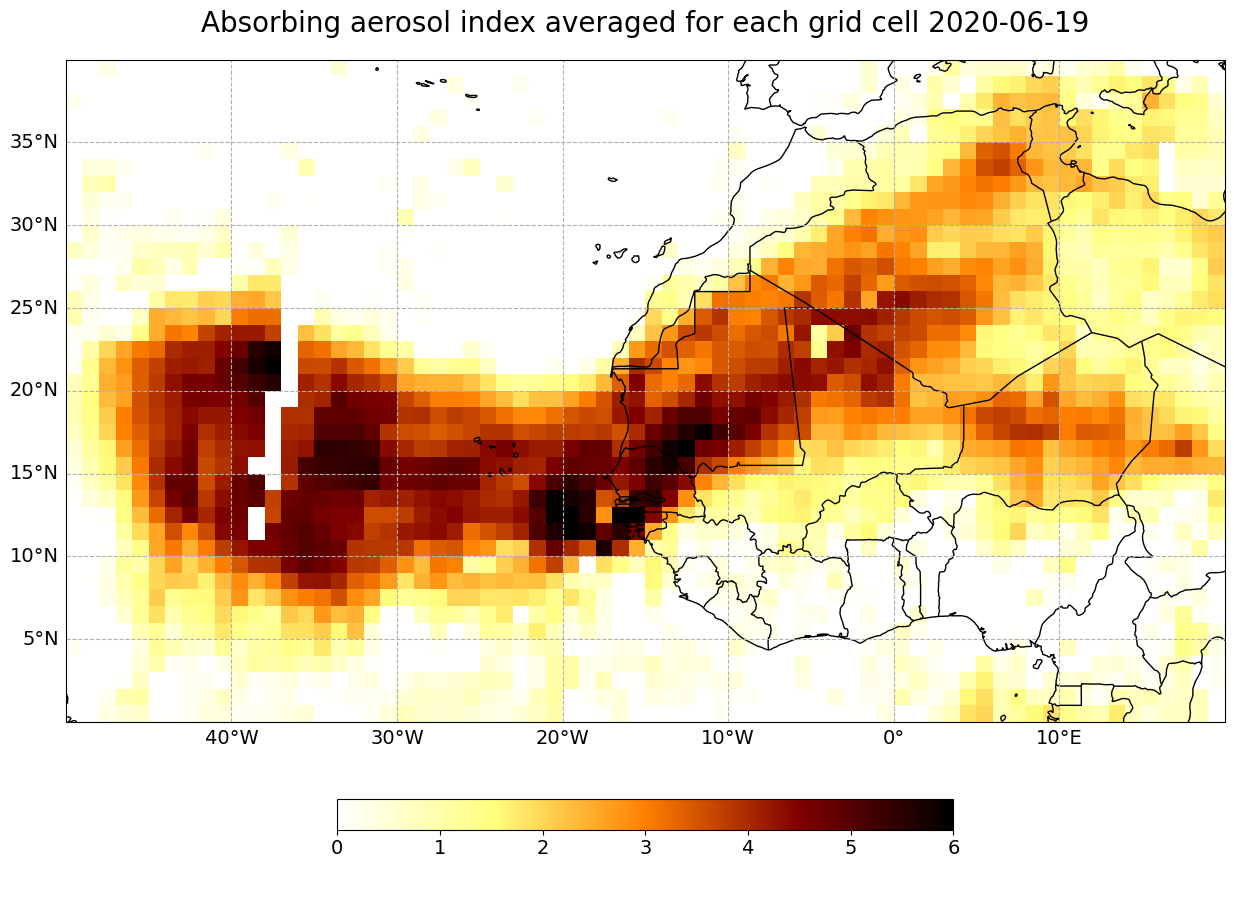

In [18]:
visualize_pcolormesh(data_array=aai_combined[5,:,:].T,
                     longitude=aai_combined.longitude, 
                     latitude=aai_combined.latitude,
                     projection=ccrs.PlateCarree(), 
                     color_scale='afmhot_r', 
                     unit=' ',
                     long_name=aai_a.long_name + ' ' + str(aai_combined.time[5].dt.strftime('%Y-%m-%d').data), 
                     vmin=0, 
                     vmax=6, 
                     lonmin=lonmin, 
                     lonmax=lonmax, 
                     latmin=latmin, 
                     latmax=latmax,
                     set_global=False)


<br>

## <a id='animate_gome2'></a>6. Animate daily Metop-A/B/C GOME-2 Level 3 Absorbing Aerosol Index (AAI) data between 14 to 19 June 2020

The final step is now to animate the `aai_combined` DataArray over the 6 days to see the dispersion of Aerosols resulting from the Saharan dust event over over the Atlantic in June 2020.

The animation function consists of four parts:
- **Setting the initial state:**<br>
 Here, you define the general plot your animation shall use to initialise the animation. You can also define the number of frames (time steps) your animation shall have.
 
 
- **Functions to animate:**<br>
 An animation consists of three functions: `draw()`, `init()` and `animate()`. `draw()` is the function where individual frames are passed on and the figure is returned as image. In this example, the function redraws the plot for each time step. `init()` returns the figure you defined for the initial state. `animate()` returns the `draw()` function and animates the function over the given number of frames (time steps).
 
 
- **Create a `animate.FuncAnimation` object:** <br>
 The functions defined before are now combined to build an `animate.FuncAnimation` object.
 
 
- **Play the animation as video:**<br>
 As a final step, you can integrate the animation into the notebook with the `HTML` class. You take the generate animation object and convert it to a HTML5 video with the `to_html5_video` function

In [19]:
# Setting the initial state:
# 1. Define figure for initial plot
fig, ax = visualize_pcolormesh(data_array=aai_combined[0,:,:].T,
                     longitude=aai_combined.longitude, 
                     latitude=aai_combined.latitude,
                     projection=ccrs.PlateCarree(), 
                     color_scale='afmhot_r', 
                     unit=' ',
                     long_name=aai_a.long_name + ' ' + str(aai_combined.time[0].dt.strftime('%Y-%m-%d').data), 
                     vmin=0, 
                     vmax=6, 
                     lonmin=lonmin, 
                     lonmax=lonmax, 
                     latmin=latmin, 
                     latmax=latmax,
                     set_global=False)

frames = len(aai_combined)

def draw(i):
    img = plt.pcolormesh(aai_combined.longitude, 
                         aai_combined.latitude, 
                         aai_combined[i,:,:].T, 
                         cmap='afmhot_r', 
                         transform=ccrs.PlateCarree(),
                         vmin=0,
                         vmax=6)
    ax.set_title(aai_a.long_name + ' ' + str(aai_combined.time[i].dt.strftime('%Y-%m-%d').data),
                fontsize=20, pad=20.0)
    return img

def init():
    return fig

def animate(i):
    return draw(i)

ani = animation.FuncAnimation(fig, animate, frames, interval=800, blit=False,
                              init_func=init, repeat=True)
HTML(ani.to_jshtml())
plt.close(fig)


<br>

#### Play the animation as HTML5 video

In [20]:
# HTML(ani.to_html5_video())
HTML(ani.to_jshtml())

<hr>

### References
* The data of the GOME-2 Absorbing Aerosol Index are provided by KNMI in the framework of the EUMETSAT Satellite Application Facility on Atmospheric Composition Monitoring (AC SAF)
* L.G. Tilstra, O.N.E. Tuinder, and P. Stammes, GOME-2 Absorbing Aerosol Index: Statistical analysis, comparison to GOME-1 and impact of instrument degradation, Proceedings of the 2010 EUMETSAT Meteorological Satellite Conference, 2010. ([PDF file](https://d37onar3vnbj2y.cloudfront.net/static/airpollution/absaai/doc/EUMETSAT2010_Tilstra_et_al.pdf))

* This notebook was adapted from: https://dustbook.ltpy.adamplatform.eu/docs/gome2_aai.html

<hr>

<img src='../img/copernicus_logo.png' alt='Logo EU Copernicus' align='right' width='20%'><br><br><br><br>

<p style="text-align:right;">This project is licensed under <a href="../../LICENSE">GNU General Public License v3.0 only</a> and is developed under a Copernicus contract.

<p style="text-align:right;"> <a href='https://training.eumetsat.int'>EUMETSAT Training</a> | <a href='mailto:training@eumetsat.int'>Contact the training team</a></p>